In [33]:
#合并四个位置数据
import pandas as pd

# 定义文件路径列表
esf_files = [
    '/Users/guodehao/Documents/python/hebei_esf_huailai_data.xlsx',
    '/Users/guodehao/Documents/python/hebei_esf_qiaoxi_data.xlsx',
    '/Users/guodehao/Documents/python/hebei_esf_xiahuayuan_data.xlsx',
    '/Users/guodehao/Documents/python/hebei_esf_zhangbei_data.xlsx'
]

zu_files = [
    '/Users/guodehao/Documents/python/hebei_zu_huailai_data.xlsx',
    '/Users/guodehao/Documents/python/hebei_zu_qiaoxi_data.xlsx',
    '/Users/guodehao/Documents/python/hebei_zu_xiahuyuan_data.xlsx',
    '/Users/guodehao/Documents/python/hebei_zu_zhangbei_data.xlsx'
]

# 要生成的文件路径，修改为 XLSX 格式
esf_parquet_path = '/Users/guodehao/Documents/python/hebei_esf_combined.xlsx'
zu_parquet_path = '/Users/guodehao/Documents/python/hebei_zu_combined.xlsx'

# 初始化空列表来存储数据帧
esf_dfs = []
zu_dfs = []

# 读取二手房文件并添加到列表
for file in esf_files:
    df = pd.read_excel(file)
    # 先将面积(㎡)列转换为字符串类型，再去除逗号并转换为数值类型
    df['面积(㎡)'] = pd.to_numeric(df['面积(㎡)'].astype(str).str.replace(',', ''), errors='coerce')
    esf_dfs.append(df)

# 合并二手房数据帧
esf_combined = pd.concat(esf_dfs, ignore_index=True)
# 删除二手房合并数据中有缺失值的行
esf_combined = esf_combined.dropna()
# 删除二手房合并数据中完全重复的行
esf_combined = esf_combined.drop_duplicates()

# 读取租房文件并添加到列表
for file in zu_files:
    df = pd.read_excel(file)
    zu_dfs.append(df)

# 合并租房数据帧
zu_combined = pd.concat(zu_dfs, ignore_index=True)
# 删除租房合并数据中有缺失值的行
zu_combined = zu_combined.dropna()
# 删除租房合并数据中完全重复的行
zu_combined = zu_combined.drop_duplicates()

# 保存为 XLSX 格式
esf_combined.to_excel(esf_parquet_path, index=False)
zu_combined.to_excel(zu_parquet_path, index=False)

# 生成单位月租金
file_path = '/Users/guodehao/Documents/python/hebei_zu_combined.xlsx'
df = pd.read_excel(file_path)
df['月租金单价（元/㎡）'] = df['租金(元/月)'] / df['面积(㎡)']
# 删除生成月租金单价后数据中有缺失值的行
df = df.dropna()
# 删除生成月租金单价后数据中完全重复的行
df = df.drop_duplicates()

# 将更新后的租房数据保存为 XLSX 格式，覆盖原文件
df.to_excel(file_path, index=False)

In [40]:
#IQR法处理异常值
import pandas as pd

# 定义输入文件路径
esf_file_path = '/Users/guodehao/Documents/python/hebei_esf_combined.xlsx'
zu_file_path = '/Users/guodehao/Documents/python/hebei_zu_combined.xlsx'

# 定义输出文件路径
esf_output_path = '/Users/guodehao/Documents/python/hebei_esf_combined_handled.xlsx'
zu_output_path = '/Users/guodehao/Documents/python/hebei_zu_combined_handled.xlsx'

# IQR 法处理异常值：若某列有异常值，则删除整个样本（整行）
def handle_outliers_iqr_delete_row(df):
    outlier_rows = set()  # 用集合存储异常值所在的行索引（避免重复）
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # 找到当前列的异常值行索引
            col_outlier_rows = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            # 将异常行索引加入集合
            outlier_rows.update(col_outlier_rows)
    # 删除所有异常行
    df_clean = df.drop(index=outlier_rows)
    return df_clean, len(outlier_rows)  # 返回清洗后的数据和删除的异常行数

# 处理二手房数据
print("二手房数据处理：")
esf_data = pd.read_excel(esf_file_path)
# 先删除缺失值行
esf_data = esf_data.dropna()
# 再删除异常值所在的行
esf_data_clean, deleted_rows = handle_outliers_iqr_delete_row(esf_data)
print(f"删除缺失值后，数据基本信息：")
esf_data_clean.info()
print(f"删除 {deleted_rows} 行异常值后，数据基本统计（数值型列）：")
print(esf_data_clean.describe().round(2))
esf_data_clean.to_excel(esf_output_path, index=False)
print(f"二手房数据已保存至 {esf_output_path}")

# 处理租房数据
print("\n租房数据处理：")
zu_data = pd.read_excel(zu_file_path)
# 先删除缺失值行
zu_data = zu_data.dropna()
# 再删除异常值所在的行
zu_data_clean, deleted_rows = handle_outliers_iqr_delete_row(zu_data)
print(f"删除缺失值后，数据基本信息：")
zu_data_clean.info()
print(f"删除 {deleted_rows} 行异常值后，数据基本统计（数值型列）：")
print(zu_data_clean.describe().round(2))
zu_data_clean.to_excel(zu_output_path, index=False)
print(f"租房数据已保存至 {zu_output_path}")

二手房数据处理：
删除缺失值后，数据基本信息：
<class 'pandas.core.frame.DataFrame'>
Index: 2040 entries, 0 to 2332
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   面积(㎡)    2040 non-null   float64
 1   总价(万)    2040 non-null   float64
 2   均价(元/㎡)  2040 non-null   int64  
 3   位置       2040 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 79.7+ KB
删除 294 行异常值后，数据基本统计（数值型列）：
         面积(㎡)   总价(万)   均价(元/㎡)
count  2040.00  2040.0   2040.00
mean     81.66    47.5   5268.87
std      32.10    24.5   1955.75
min       1.00     6.5    551.00
25%      60.20    30.0   3883.75
50%      85.00    43.0   5000.00
75%     101.52    60.0   6442.00
max     170.71   128.8  12049.00
二手房数据已保存至 /Users/guodehao/Documents/python/hebei_esf_combined_handled.xlsx

租房数据处理：
删除缺失值后，数据基本信息：
<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, 0 to 654
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      ----

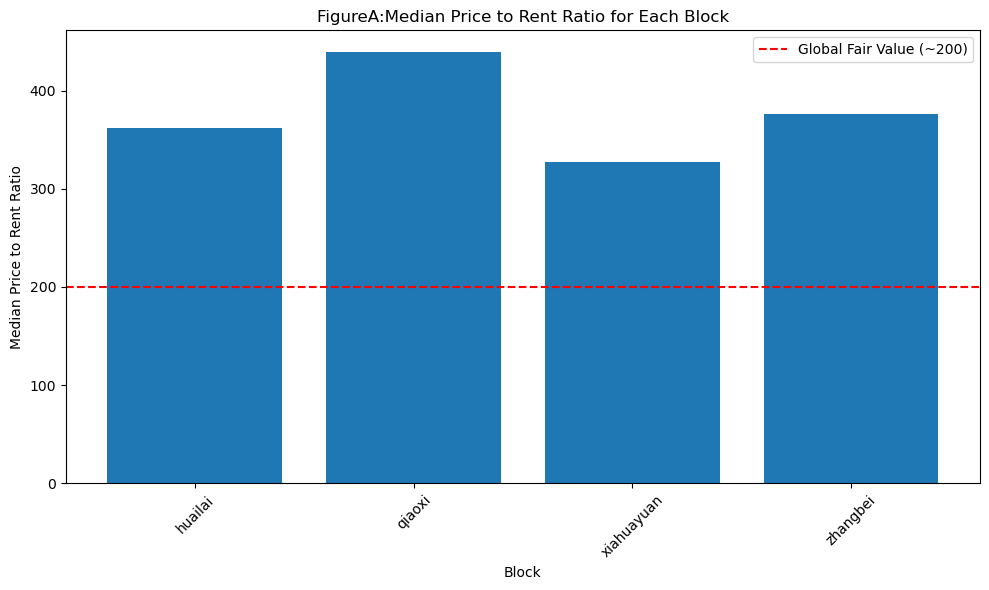

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取二手房数据（含单价）
esf_path = '/Users/guodehao/Documents/python/hebei_esf_combined_handled.xlsx'
esf_df = pd.read_excel(esf_path)

# 读取租房数据（含月租金单价）
zu_path = '/Users/guodehao/Documents/python/hebei_zu_combined_handled.xlsx'
zu_df = pd.read_excel(zu_path)

# 确保“位置”列格式一致（示例：转为字符串）
esf_df['位置'] = esf_df['位置'].astype(str)
zu_df['位置'] = zu_df['位置'].astype(str)

# 按“位置”分组，计算每组的中位数单价和中位数月租金单价
esf_median = esf_df.groupby('位置')['均价(元/㎡)'].median().reset_index()
zu_median = zu_df.groupby('位置')['月租金单价（元/㎡）'].median().reset_index()

# 合并两表（按“位置”关联）
merged_df = pd.merge(esf_median, zu_median, on='位置', how='inner')

# 计算房价租金比（price to rent ratio）
merged_df['price_to_rent_ratio'] = merged_df['均价(元/㎡)'] / merged_df['月租金单价（元/㎡）']

# 按“位置”分组，计算房价租金比的中位数
block_median_ratio = merged_df.groupby('位置')['price_to_rent_ratio'].median().reset_index()
block_median_ratio.columns = ['block', 'median_price_to_rent_ratio']

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.bar(block_median_ratio['block'], block_median_ratio['median_price_to_rent_ratio'])
plt.title('FigureA:Median Price to Rent Ratio for Each Block')
plt.xlabel('Block')
plt.ylabel('Median Price to Rent Ratio')
plt.axhline(y=200, color='r', linestyle='--', label='Global Fair Value (~200)')
plt.legend()
plt.xticks(rotation=45)  # 旋转x轴标签，避免重叠
plt.tight_layout()  # 自动调整布局
plt.show()

模型评估指标：
均方误差 (MSE): 9.79
决定系数 (R²): 0.2801

模型系数（特征对租金的影响）：
位置_qiaoxi: -0.6835
位置_xiahuayuan: -3.0201
位置_zhangbei: -2.5526
面积(㎡): -0.0713
截距 (Intercept): 20.0585


/var/folders/8l/g0hctkz16xx0qc01q5dt4dvc0000gn/T/ipykernel_10258/2799712373.py:76: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from font(s) Songti SC.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


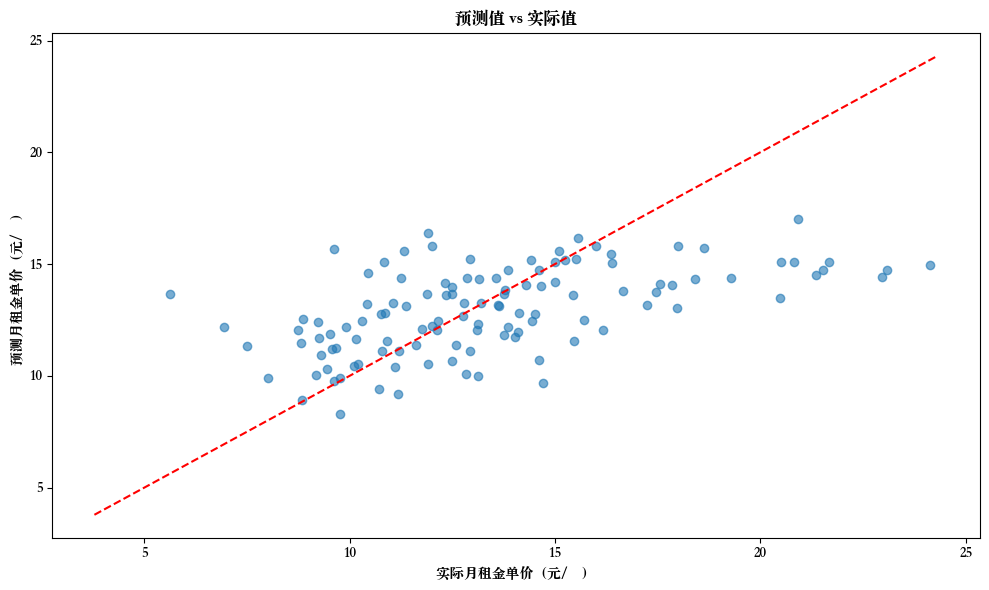

In [54]:
#线性模型
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 读取数据（使用租房数据文件）
file_path = '/Users/guodehao/Documents/python/hebei_zu_combined_handled.xlsx'
df = pd.read_excel(file_path)

# 选择需要的列
data = df[['面积(㎡)', '位置', '月租金单价（元/㎡）']].dropna()  # 确保无缺失值

# 划分特征和目标变量
X = data[['面积(㎡)', '位置']]  # 特征：面积和位置
y = data['月租金单价（元/㎡）']  # 目标变量：月租金单价

# 划分训练集和测试集（8:2）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义预处理：对位置进行独热编码（虚拟变量0/1），面积保持不变
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['位置']),  # 对位置列进行独热编码，drop避免多重共线性
        ('num', 'passthrough', ['面积(㎡)'])  # 数值列直接保留
    ])

# 创建线性回归模型 pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 训练模型
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"模型评估指标：")
print(f"均方误差 (MSE): {mse:.2f}")
print(f"决定系数 (R²): {r2:.4f}")

# 提取模型系数（分析特征影响）
# 获取特征名称（位置的虚拟变量 + 面积）
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
location_features = ohe.get_feature_names_out(['位置'])
feature_names = np.concatenate([location_features, ['面积(㎡)']])

# 系数和截距
coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

print("\n模型系数（特征对租金的影响）：")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")
print(f"截距 (Intercept): {intercept:.4f}")


plt.rcParams["font.family"] = ["SONGTI SC"]

# 可视化预测值与实际值
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 理想线
plt.xlabel('实际月租金单价（元/㎡）')
plt.ylabel('预测月租金单价（元/㎡）')
plt.title('预测值 vs 实际值')
plt.tight_layout()
plt.show()

模型性能对比（R²值，越接近1越好）：
基础模型（仅位置和面积线性项）: 0.2725
优化模型（含二次项和交叉项）: 0.3158

基础模型系数分析（正值表示正影响，绝对值越大影响越强）：
      特征      系数
1   位置_1 -3.0317
2   位置_2 -2.4601
0   位置_0 -0.8128
3  面积(㎡) -0.0735

优化模型系数分析（正值表示正影响，绝对值越大影响越强）：
          特征      系数
2       位置_2 -7.4443
0       位置_0 -5.6086
1       位置_1 -4.9176
3      面积(㎡) -0.2262
7  位置_2_x_面积  0.0617
5  位置_0_x_面积  0.0563
6  位置_1_x_面积  0.0172
4   面积(㎡)_平方  0.0006


/var/folders/8l/g0hctkz16xx0qc01q5dt4dvc0000gn/T/ipykernel_10258/2664968319.py:114: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from font(s) Songti SC.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


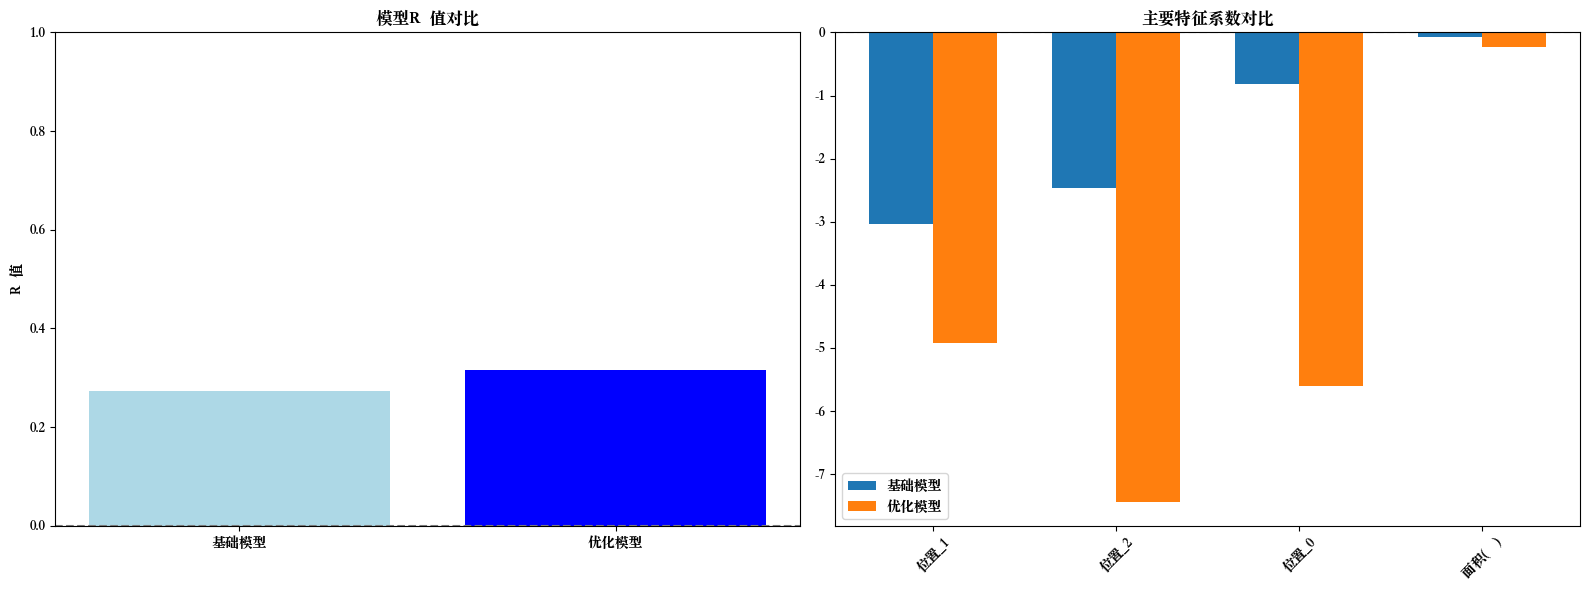


样本数据预测结果：
   面积(㎡)       位置  基础模型预测租金  优化模型预测租金
0     50  huailai     16.75     18.70
1     80   qiaoxi     13.73     13.28
2    120  huailai     11.60     10.41


In [58]:
#优化模型
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import r2_score

# 设置中文字体，确保中文正常显示
plt.rcParams["font.family"] = ["SONGTI SC"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 1. 读取数据
file_path = '/Users/guodehao/Documents/python/hebei_zu_combined_handled.xlsx'
df = pd.read_excel(file_path)

# 筛选所需列并删除缺失值
required_cols = ['面积(㎡)', '位置', '月租金单价（元/㎡）']
df = df[required_cols].dropna().copy()

# 2. 特征工程（生成二次项和交叉项）
def create_features(df):
    # 独热编码位置特征（生成0/1虚拟变量）
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    location_encoded = ohe.fit_transform(df[['位置']])
    location_cols = [f'位置_{i}' for i in range(location_encoded.shape[1])]
    location_df = pd.DataFrame(location_encoded, columns=location_cols)
    
    # 生成面积的二次项
    poly = PolynomialFeatures(degree=2, include_bias=False)
    area_poly = poly.fit_transform(df[['面积(㎡)']])
    area_cols = ['面积(㎡)', '面积(㎡)_平方']
    area_df = pd.DataFrame(area_poly, columns=area_cols)
    
    # 生成位置与面积的交叉项（交互项）
    interaction_terms = []
    interaction_cols = []
    for col in location_cols:
        interaction = location_df[col] * df['面积(㎡)']
        interaction_terms.append(interaction)
        interaction_cols.append(f'{col}_x_面积')
    interaction_df = pd.DataFrame(np.column_stack(interaction_terms), columns=interaction_cols)
    
    # 合并所有特征
    features = pd.concat([location_df, area_df, interaction_df], axis=1)
    return features, ohe, location_cols

# 创建特征集和目标变量
X, ohe, location_cols = create_features(df)
y = df['月租金单价（元/㎡）']

# 3. 构建并训练模型（基础模型 vs 优化模型）
# 基础模型（仅线性项：位置 + 面积）
base_feature_cols = location_cols + ['面积(㎡)']
base_model = LinearRegression().fit(X[base_feature_cols], y)

# 优化模型（线性项 + 二次项 + 交叉项）
optimized_model = LinearRegression().fit(X, y)

# 4. 模型评估（R²对比）
base_r2 = r2_score(y, base_model.predict(X[base_feature_cols]))
optimized_r2 = r2_score(y, optimized_model.predict(X))

print("模型性能对比（R²值，越接近1越好）：")
print(f"基础模型（仅位置和面积线性项）: {base_r2:.4f}")
print(f"优化模型（含二次项和交叉项）: {optimized_r2:.4f}")

# 5. 模型系数分析
def analyze_coefficients(model, feature_names, model_name):
    print(f"\n{model_name}系数分析（正值表示正影响，绝对值越大影响越强）：")
    coefficients = pd.DataFrame({
        '特征': feature_names,
        '系数': model.coef_
    }).sort_values(by='系数', key=abs, ascending=False)
    print(coefficients.round(4))
    return coefficients

# 分析两个模型的系数
base_coef = analyze_coefficients(base_model, base_feature_cols, "基础模型")
optimized_coef = analyze_coefficients(optimized_model, X.columns, "优化模型")

# 6. 可视化结果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 子图1: R²对比
models = ['基础模型', '优化模型']
r2_scores = [base_r2, optimized_r2]
axes[0].bar(models, r2_scores, color=['lightblue', 'blue'])
axes[0].axhline(y=0, color='gray', linestyle='--')
axes[0].set_title('模型R²值对比')
axes[0].set_ylabel('R²值')
axes[0].set_ylim(0, 1)

# 子图2: 主要特征系数对比（取前8个影响最大的特征）
top_features = pd.concat([
    base_coef.head(4)['特征'], 
    optimized_coef.head(4)['特征']
]).unique()[:8]

base_coef_plot = base_coef.set_index('特征').reindex(top_features).fillna(0)
optimized_coef_plot = optimized_coef.set_index('特征').reindex(top_features).fillna(0)

x = np.arange(len(top_features))
width = 0.35

axes[1].bar(x - width/2, base_coef_plot['系数'], width, label='基础模型')
axes[1].bar(x + width/2, optimized_coef_plot['系数'], width, label='优化模型')
axes[1].set_title('主要特征系数对比')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_features, rotation=45)
axes[1].axhline(y=0, color='gray', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()

# 7. 预测示例
sample_data = pd.DataFrame({
    '面积(㎡)': [50, 80, 120],
    '位置': [df['位置'].unique()[0], df['位置'].unique()[1], df['位置'].unique()[0]]
})

# 为样本数据创建特征
def create_sample_features(sample_df, ohe, location_cols):
    location_encoded = ohe.transform(sample_df[['位置']])
    location_df = pd.DataFrame(location_encoded, columns=location_cols)
    
    poly = PolynomialFeatures(degree=2, include_bias=False)
    area_poly = poly.fit_transform(sample_df[['面积(㎡)']])
    area_df = pd.DataFrame(area_poly, columns=['面积(㎡)', '面积(㎡)_平方'])
    
    interaction_terms = []
    interaction_cols = [f'{col}_x_面积' for col in location_cols]
    for col in location_cols:
        interaction = location_df[col] * sample_df['面积(㎡)']
        interaction_terms.append(interaction)
    interaction_df = pd.DataFrame(np.column_stack(interaction_terms), columns=interaction_cols)
    
    return pd.concat([location_df, area_df, interaction_df], axis=1)

sample_features = create_sample_features(sample_data, ohe, location_cols)
sample_data['基础模型预测租金'] = base_model.predict(sample_features[base_feature_cols])
sample_data['优化模型预测租金'] = optimized_model.predict(sample_features)

print("\n样本数据预测结果：")
print(sample_data.round(2))

从结果看，优化模型（含非线性和交互项）的R方高于基础线性模型，说明其对租金的解释能力更强。若样本量充足，应优先信任加入非线性项与交互项的模型（第三种方法）得出的房价租金比。因为充足的样本能让模型充分学习面积、位置等特征间的非线性和交互关系，让模型更精准拟合数据，进而使房价租金比的计算更贴合真实情况；而若样本量小，复杂模型易因数据不足出现过拟合，此时基于简单线性关系的方法（第一种方法）得出的结果相对更可靠。